## Imports and Utility

In [62]:
import tweepy
import sys
import jsonpickle
import json
import os
import nltk
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.dates as mdates
from scipy.stats.stats import pearsonr

pd.set_option('display.max_colwidth', -1)

sns.set_style("darkgrid")
%matplotlib inline
#nltk.download()

def saveTweets(auth,query,max_tweets,fn):
    api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
    with open(fn+'.json', 'w') as f:
        tweets = []
        last_id = -1
        while len(tweets) < max_tweets:
            count = max_tweets - len(tweets)
            try:
                new_tweets = api.search(q=query, count=count, max_id=str(last_id - 1),tweet_mode='extended')
                if not new_tweets:
                    break
                tweets.extend(new_tweets)
                last_id = new_tweets[-1].id
            except tweepy.TweepError as e:
                print(str(e))
                break
        for tweet in tweets:
            f.write(jsonpickle.encode(tweet._json, unpicklable=False) +'\n')
        return True

def loadTweets(fn):
    with open(fn+'.json', 'r') as f:
        data = f.readlines()
        return [json.loads(i) for i in data]
    
def get_words(twts):
    rawtext = ' '.join(twts).lower()
    words = re.sub(r'[^a-zA-Z#\s]', '', rawtext).split()
    sw = nltk.corpus.stopwords.words('english')
    sw.extend(['rt','&amp;'])
    return [w for w in words if w not in sw]

def get_sigstar(p):
    if p<0.001:
        sig = '***'
    elif p<0.01:
        sig = '**'
    elif p<=0.05:
        sig = '*'
    elif p>0.05:
        sig = 'n.s.'
    return sig

## Get tweets from twitter API

In [93]:
query = '#datascience AND python'
fn='datascience'

with open ("auth.txt", "r") as f:
    cred=f.readlines()
cred = [i.rstrip() for i in cred]
auth = tweepy.AppAuthHandler(cred[0],cred[1])
saveTweets(auth,query,5000,fn)

## Load tweets into dataframe

In [95]:
tweets = loadTweets(fn)
print('Total tweets:',len(tweets))
df = pd.DataFrame(
    dict(
        op=[t['user']['name'] for t in tweets],
        text=[t['full_text'] for t in tweets],
        RT=[True if i['retweeted'] or 'RT @' in i['full_text'] else False for i in tweets],
        fcount=[t['favorite_count'] for t in tweets],
        rtcount=[t['retweet_count'] for t in tweets],
        uloc=[t['user']['location'] for t in tweets],
        ufol=[t['user']['followers_count'] for t in tweets],
        time= pd.to_datetime([t['created_at'] for t in tweets])
    )
)
df.sort_values(by='time',inplace=True)
df.reset_index(inplace=True,drop=True)
print('Total retweets:',sum(df['RT']))
print('Total original tweets:',len(tweets)-sum(df['RT']))

Total tweets: 5000
Total retweets: 4309
Total original tweets: 691


## Word frequencies

In [96]:
top = nltk.FreqDist(get_words(df['text'])).most_common(20)
top_orig = nltk.FreqDist(get_words(df[df['RT']==False]['text'])).most_common(20)

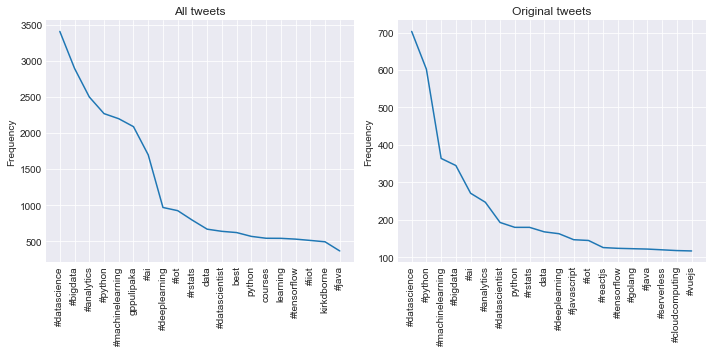

In [97]:
f = plt.figure(figsize=(10,5))

ax1=f.add_subplot(1,2,1)
ax1.plot([i[0] for i in top], [i[1] for i in top])
plt.xticks(rotation=90);
ax1.set_ylabel('Frequency')
ax1.set_title('All tweets')

ax2=f.add_subplot(1,2,2)
ax2.plot([i[0] for i in top_orig], [i[1] for i in top_orig])
plt.xticks(rotation=90);
ax2.set_ylabel('Frequency')
ax2.set_title('Original tweets')

f.tight_layout()

## Number of tweets over time

If this doesn't plot, there's likely only one days worth of tweets in the dataset.

Text(0.5,0,'Date')

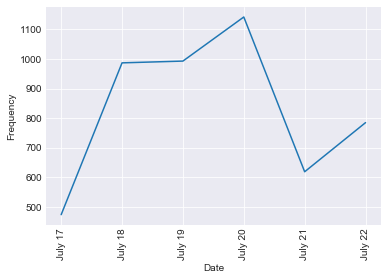

In [98]:
days=df.resample('D',on='time').count()
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%B %d'))
ax.plot(days.index,days['op'])
plt.xticks(rotation=90);
ax.set_ylabel('Frequency')
ax.set_xlabel('Date')

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


(0, 23)

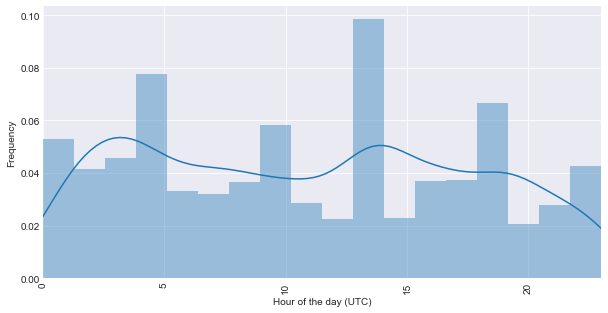

In [99]:
hod = [r.hour for r in df.time]
plt.figure(figsize=(10,5))
sns.distplot(hod)
plt.xticks(rotation=90);
plt.ylabel('Frequency')
plt.xlabel('Hour of the day (UTC)')
plt.xlim(0,23)

## Most favourited

In [119]:
frtcor = pearsonr(df[df['RT']==False]['fcount'],df[df['RT']==False]['rtcount'])
print('Correlation between favourite and retweet counts is',round(frtcor[0],2),get_sigstar(frtcor[1]))
df[df['RT']==False][['op','text','time','fcount']].sort_values(by='fcount',ascending=False).head()

Correlation between favourite and retweet counts is 0.83 ***


,op,text,time,fcount
1651,Kirk Borne,How to Remotely Send R and #Python Execution to #SQLServer from #Jupyter Notebooks or any IDE: https://t.co/hpVEYVYrOT #abdsc #BigData #DataScience #Rstats #AI #MachineLearning https://t.co/lIQgU0eJcB,2018-07-19 04:48:48,177
4055,Omoathebu Esther,"I've been learning Python for a while now but I've not been serious with it. So, I'm publicly committing to the 100DaysOfCode Challenge starting today! #100DaysOfCode\n#womenwhocode \n#python \n#DataScience",2018-07-21 19:56:37,92
4279,"Mike Tamir, PhD",A Feature Selection Tool for Machine Learning in Python https://t.co/4vSZSFwbez #AI #DeepLearning #MachineLearning #DataScience https://t.co/RddwcQkOnx,2018-07-22 01:29:03,70
569,Dr. GP Pulipaka,Big Data and Container Orchestration with Kubernetes (K8s). #BigData #Analytics #MachineLearning #DataScience #AI #Python #RStats #TensorFlow #Java #JavaScript #ReactJS #VueJS #GoLang #CloudComputing #Serverless #DataScientist #Kubernetes #Docker \nhttps://t.co/fYdKIKB8Ds https://t.co/fudHVQXsuI,2018-07-18 03:26:03,69
2775,Kirk Borne,Creating Your First #MachineLearning Classifier with Scikit-learn: https://t.co/iMjy0QKF1j #abdsc #BigData #DataScience #Python #coding #DataScientists https://t.co/jlqxQ7Wvh8,2018-07-20 04:31:58,68


## Most retweeted

Note that sometimes the retweet status doesn't make it's way into the json. I compensated for it above, but this is not reflected in the 'rtcount' variable. For a more exact number, some more coding is needed. May implement at some point.

In [102]:
df[df['RT']==False][['op','text','time','rtcount']].sort_values(by='rtcount',ascending=False).head()

,op,text,time,rtcount
1651,Kirk Borne,How to Remotely Send R and #Python Execution to #SQLServer from #Jupyter Notebooks or any IDE: https://t.co/hpVEYVYrOT #abdsc #BigData #DataScience #Rstats #AI #MachineLearning https://t.co/lIQgU0eJcB,2018-07-19 04:48:48,114
4394,Kirk Borne,Top Languages &amp; Tools according to Data Professionals (from the @PacktPub 2018 Skill Up Developer Skills survey) https://t.co/mHBB6PbB5w #abdsc #BigData #DataScience #DataScientists #Coding #Python #Rstats #SQL #Javascript #MachineLearning #NLProc https://t.co/C4rGccHdU6,2018-07-22 03:32:59,72
569,Dr. GP Pulipaka,Big Data and Container Orchestration with Kubernetes (K8s). #BigData #Analytics #MachineLearning #DataScience #AI #Python #RStats #TensorFlow #Java #JavaScript #ReactJS #VueJS #GoLang #CloudComputing #Serverless #DataScientist #Kubernetes #Docker \nhttps://t.co/fYdKIKB8Ds https://t.co/fudHVQXsuI,2018-07-18 03:26:03,63
2807,Kirk Borne,Survey results from https://t.co/s7Y7qSW4eE &gt;&gt; The Typical #DataScientist Profile: https://t.co/f2mpOZh15W #abdsc #BigData #DataScience #MachineLearning #AI #Python #Rstats https://t.co/US5Kk6fxVa,2018-07-20 04:40:42,49
1994,Dr. GP Pulipaka,CoinAI: Seed Applications Based on AI for Digital Currency. #BigData #Analytics #Hadoop #MachineLearning #DataScience #AI #FinTech #BlockChain #Python #RStats #TensorFlow #JavaScript #ReactJS #VueJS #GoLang #CloudComputing #Serverless #DataScientist #AWS \nhttps://t.co/eukKmwVLtT https://t.co/JwBiENuBFa,2018-07-19 14:26:07,43


## Most influential users

In [118]:
inf = pd.DataFrame(dict(
    user = np.unique(df['op']),
    followers = [df[df['op']==i]['ufol'].iloc[0] for i in np.unique(df['op'])],
    toptweet = [df[df['op']==i].sort_values(by='rtcount')['text'].iloc[0] for i in np.unique(df['op'])]
))
inf.sort_values(by='followers',ascending=False).head()

,user,followers,toptweet
700,Kirk Borne,202239,"Top resources this week in #BigData #DataScience #MachineLearning #Blockchain #AI #NLProc #Python, R, SQL, #ApacheSpark, Regression... at @DataScienceCtrl https://t.co/hKmcNvze6T #abdsc #Rstats #DataScientists https://t.co/HUyELrgqSr"
322,Data Science Central,185409,RT @KirkDBorne: Comparison of Top 6 #Python #NLProc Libraries — Pros and Cons: https://t.co/BLPzMb72lW #abdsc #BigData #DataScience #AI #Ma…
1043,Ronald van Loon,143681,#MachineLearning in #Python\n by @plusbzz @Springboard | \n\nRead more here: https://t.co/SmzHyJehi1\n\n#ML #DataScience #DataScientist #SupervisedLearning #UnsupervisedLearning #NeuralNetworks #RT\n\ncc: @flowingdata @hugo_larochelle @wesmckinn @bigdatagal @jackclarksf https://t.co/bo2RdEnMXM
1451,الحكمة,138964,"RT @IECCUK: Study in @london for a UK degree in the coming September intake, 2018. At, @IECCUK we have dedicated study abroad programme for…"
683,KDnuggets,121499,Comprehensive Guide to Learning #Python for Data Analysis and #DataScience #KDN https://t.co/9swx0Uz2aQ
